### Building ChatBot with Multiple Tools Using LangGraph

Create a ChatBot with Tool Capabilities from arxiv wikipedia search and some functions
- Arxiv's library contains all the research Papers 


In [3]:
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import  WikipediaAPIWrapper, ArxivAPIWrapper


In [6]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)


arxiv


In [7]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [9]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper = api_wrapper_wiki)
wiki.name

'wikipedia'

In [10]:
wiki.invoke("What is machine learning")


'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [11]:
from dotenv import load_dotenv
load_dotenv()
import os

In [ ]:
os.environ["tavily_api_key"] = os.getenv("tavilyAPI")
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_api_key = os.getenv("tavilyAPI")
tavily = TavilySearchResults(tavily_api_key=tavily_api_key)


#### Tavily is cool, it can be used everyday for news!

In [21]:
tavily.invoke("Provide me the recent AI news of Jan 3rd 2026")

[{'title': 'AI in Jan. 2026: Three Critical Global Decisions',
  'url': 'https://etcjournal.com/2025/12/28/ai-in-jan-2026-three-critical-global-decisions-global-ai-operating-system/',
  'content': "The three most pressing AI decisions for January 2026 are about (1) whether nations converge on compatible AI governance or double down on fragmentation, (2) how far governments go in centralizing control over frontier compute and models, and (3) whether leading actors treat AI as a driver of shared development or as a zero‑sum geopolitical weapon. Each of these is crystallizing in late‑December moves by major governments and blocs, and each will shape how safe, open, and globally accessible AI [...] |  |  |\n --- |\n|  | 2026年、AIは「道具」から「自律する… on AI in Jan. 2026: Three Critica… |\n|  | Top 7 AI Round up 20… on Three Biggest AI Stories in Oc… |\n|  | Inside xAI: Musk is… on Is Colossus the “Largest… |\n|  | HigherEd AI Daily: J… on Ed Tech in Higher Ed – Three I… |\n| Unknown's avatar | Anony

In [22]:
tools = [arxiv, wiki, tavily]


In [23]:
from langchain_groq import ChatGroq

groqAPI = os.getenv("groqAPI")


llm = ChatGroq(
    model = "qwen/qwen3-32b",
    api_key = groqAPI
)

llm_with_tools = llm.bind_tools(tools)

In [26]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content = f"What is the recent AI news")])


AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about recent AI news. I need to figure out which tool to use here. Let\'s see, the available tools are arxiv, wikipedia, and tavily_search_results_json.\n\nArxiv is for scientific papers, which might be too technical and not the best for general news. Wikipedia is good for general knowledge but might not have the most up-to-date information. The user mentioned "recent" news, so they probably want the latest updates. Tavily_search_results_json is described as a search engine optimized for current events. That sounds like the right choice here. I should use that to get the latest AI news. The query parameter should be "recent AI news" to match their request. Let me make sure the parameters are correctly formatted. Yep, the function requires a query string. So I\'ll call tavily_search_results_json with the query "recent AI news".\n', 'tool_calls': [{'id': 'gayykgpr1', 'function': {'arguments': '{"query

#### Here Groq doesn't directly give output, instead it use the external provided tool - Tavily

Tavily - Internet Search Engine

In [27]:
result = llm_with_tools.invoke([HumanMessage(content = f"What is the recent AI news")])
result.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'wj8500jnh',
  'type': 'tool_call'}]

### Entire ChatBot With LangGraph

In [29]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode,  tools_condition

In [37]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict) :
    messages : Annotated[list[AnyMessage], add_messages]
    


In [ ]:
# Node Definition
def tool_calling_llm(state : State) :
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}


# Build Graph
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", tools_condition
)

builder.add_edge("tools", END)

graph = builder.compile()


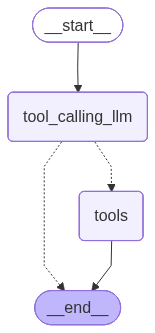

In [42]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
messages = graph.invoke({"messages" : HumanMessage(content = "What is attention all you need")})

for m in messages['messages'] :
    m.pretty_print()
    

================================ Human Message =================================

What is attention all you need
================================== Ai Message ==================================
Tool Calls:
  arxiv (73fdyyg2p)
 Call ID: 73fdyyg2p
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi


In [44]:
messages = graph.invoke({"messages" : HumanMessage(content = "What is NLP?")})

for m in messages['messages'] :
    m.pretty_print()
    

================================ Human Message =================================

What is NLP?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (1ga188ykj)
 Call ID: 1ga188ykj
  Args:
    query: Natural Language Processing
================================= Tool Message =================================
Name: wikipedia

Page: Natural language processing
Summary: Natural language processing (NLP) is the processing of natural language information by a computer. NLP is a subfield of computer science and is closely associated with artificial intelligence. NLP is also related to information retrieval, knowledge representation, computational linguistics, and linguistics more broadly.
Major processing tasks in an NLP system include: speech recognition, text classification, natural language understanding, and natural l


In [45]:
messages = graph.invoke({"messages" : HumanMessage(content = "What is Kotlin?")})

for m in messages['messages'] :
    m.pretty_print()
    

================================ Human Message =================================

What is Kotlin?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (fpfv574de)
 Call ID: fpfv574de
  Args:
    query: Kotlin (programming language)
================================= Tool Message =================================
Name: wikipedia

Page: Kotlin
Summary: Kotlin () is a cross-platform, statically typed, general-purpose high-level programming language with type inference. Kotlin is designed to interoperate fully with Java, and the JVM version of Kotlin's standard library depends on the Java Class Library,
but type inference allows its syntax to be more concise. Kotlin mainly targets the JVM, but also compiles to JavaScript (e.g. for frontend web applications using React) or native code via LLVM (e.g. for native iOS apps shari
